In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy
import time

from models.sub_clust_cos_glm import Sub_Clust_Cos_GLM
from models.clust_gru import Clust_GRU

# Hyperparameters

In [2]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60_noNA"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"
V_file = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_noDendNa_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
#V_file = "V_diff.npy"
eloc_file = "Elocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_noDendNa_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
iloc_file = "Ilocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_noDendNa_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)[:,:50000].flatten()
#V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
V = torch.from_numpy(V)
V -= torch.mean(V)
eloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+eloc_file)
iloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+iloc_file)

den_idx = np.unique(eloc[880:1120,0])
e_idx = np.where(np.isin(eloc[:,0], den_idx) == True)[0]
i_idx = np.where(np.isin(iloc[:,0], den_idx) == True)[0]
e_idx = torch.from_numpy(e_idx)
i_idx = torch.from_numpy(i_idx)

In [3]:
T_train = 995 * 1000 * 50
T_test = 1 * 1000 * 50
H_no = 2
sub_no = 7
E_no = 2000
I_no = 200
#E_no = 299
#I_no = 8
T_no = 500
device = torch.device("cuda")

increment = 50
batch_length = 50000
batch_size = 5
iter_no = 9950*2
epoch_no = iter_no*batch_length*batch_size//T_train 

# Preprocess

In [4]:
V_train = V[:T_train].float()
V_test = V[-50000:].to(device).float()

test_E_neural = E_neural[-50000:].toarray()
test_I_neural = I_neural[-50000:].toarray()
train_E_neural = E_neural[:T_train]
train_I_neural = I_neural[:T_train]

test_E_neural = torch.from_numpy(test_E_neural).float().to(device)
test_I_neural = torch.from_numpy(test_I_neural).float().to(device)

train_idx = np.empty((epoch_no, T_train//batch_length//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_length*batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

# Train

In [5]:
model = Sub_Clust_Cos_GLM(sub_no, E_no, I_no, T_no, H_no, device)
#model = Clust_GRU(sub_no, E_no, I_no, H_no, device)
syn_params = []
rest_params = []

for name, params in model.named_parameters():
    if (name == "C_syn_e_raw") or (name == "C_syn_i_raw"):
        syn_params.append(params)
    else:
        rest_params.append(params)

# GLM
optimizer = torch.optim.Adam(rest_params, lr = 0.005/(1.03**100))
syn_optimizer = torch.optim.Adam(syn_params, lr = 0.005)
milestones = np.arange(increment-1, increment*100, increment)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=1)
syn_scheduler = torch.optim.lr_scheduler.StepLR(syn_optimizer, step_size=increment, gamma=0.96)

# GRU
optimizer = torch.optim.Adam(rest_params, lr = 0.005/(1.03**100))
syn_optimizer = torch.optim.Adam(syn_params, lr = 0.005)
milestones = np.arange(increment-1, increment*100, increment)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=1)
syn_scheduler = torch.optim.lr_scheduler.StepLR(syn_optimizer, step_size=increment, gamma=0.96)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

print(sum(p.numel() for p in syn_params if p.requires_grad))
print(sum(p.numel() for p in rest_params if p.requires_grad))
print(milestones.shape)

18301
15400
2901
(100,)


In [6]:
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

score_list = []
temp_list = np.logspace(0,-3,100)
temp_count = 0

for i in tnrange(iter_no):
    model.train()
    optimizer.zero_grad()
    syn_optimizer.zero_grad()
           
    with torch.no_grad():
        model.C_syn_e_raw.copy_(model.C_syn_e_raw - torch.mean(model.C_syn_e_raw, 0).reshape(1,-1))
        model.C_syn_i_raw.copy_(model.C_syn_i_raw - torch.mean(model.C_syn_i_raw, 0).reshape(1,-1))
    
    if (temp_count < 99) & (i%increment == increment-1):
        temp_count += 1
    temp = temp_list[temp_count]
    
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_I_neural = torch.from_numpy(batch_I_neural).float().to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_length*batch_size].reshape(batch_size, -1).to(device)
    
    V_pred, _, _, _  = model(batch_E_neural, batch_I_neural, temp)    
    loss = torch.mean((V_pred - batch_V[:,:])**2) 
    
    loss.backward()
    optimizer.step()
    scheduler.step()
    syn_optimizer.step()
    syn_scheduler.step()
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        test_V_pred, test_sub_out, test_C_syn_e, test_C_syn_i = model(test_E_neural.unsqueeze(0), test_I_neural.unsqueeze(0), 0.0001)
        test_V_pred = test_V_pred.flatten()
                 
        test_score = explained_variance_score(V_test[:].cpu().detach().numpy(), test_V_pred.cpu().detach().numpy())
        test_mse = torch.mean((V_test[:]-test_V_pred)**2).item()
        score_list.append(test_score)
        
        C_syn_idx = torch.argmax(test_C_syn_e[:,880:1120], 0).float()
        
        mode1, mode1_idx = torch.mode(C_syn_idx[:60])
        mode2, mode2_idx = torch.mode(C_syn_idx[60:120])
        mode3, mode3_idx = torch.mode(C_syn_idx[120:180])
        mode4, mode4_idx = torch.mode(C_syn_idx[180:240])
        mode1_no = torch.numel(torch.where(C_syn_idx[:60] == mode1)[0])
        mode2_no = torch.numel(torch.where(C_syn_idx[60:120] == mode2)[0])
        mode3_no = torch.numel(torch.where(C_syn_idx[120:180] == mode3)[0])
        mode4_no = torch.numel(torch.where(C_syn_idx[180:240] == mode4)[0])
                        
        print(i, np.round(test_score,6),
              np.round(1/temp, 6))
        print(mode1.item(), mode2.item(), mode3.item(), mode4.item())
        print(mode1_no, mode2_no, mode3_no, mode4_no)
        print("------------------------")

0 0.108971 1.0 0.000296 0.000304
3.0 6.0 3.0 6.0
19 19 20 21
------------------------
49 0.420308 1.072267 0.000288 0.001323
3.0 3.0 3.0 3.0
59 60 57 60
------------------------
99 0.497128 1.149757 0.00028 0.003897
3.0 3.0 3.0 3.0
60 60 58 58
------------------------
149 0.525203 1.232847 0.000277 0.00647
3.0 3.0 3.0 3.0
60 60 60 60
------------------------
199 0.531528 1.321941 0.00027 0.008319
3.0 6.0 6.0 6.0
50 30 59 58
------------------------
249 0.619901 1.417474 0.000258 0.010291
3.0 4.0 6.0 6.0
31 34 60 60
------------------------
299 0.615396 1.519911 0.000248 0.012187
4.0 4.0 6.0 6.0
39 49 60 58
------------------------
349 0.605181 1.629751 0.000242 0.014035
4.0 4.0 6.0 6.0
46 53 58 52
------------------------
399 0.609208 1.747528 0.000238 0.015802
4.0 4.0 6.0 6.0
46 56 59 47
------------------------
449 0.604129 1.873817 0.000236 0.017524
4.0 4.0 6.0 3.0
46 58 56 31
------------------------
499 0.59949 2.009233 0.000234 0.019003
4.0 4.0 6.0 3.0
46 59 54 41
---------------

4399 0.785414 464.158883 0.001299 0.041239
4.0 4.0 6.0 3.0
55 48 45 46
------------------------
4449 0.818448 497.702356 0.00132 0.041212
4.0 4.0 6.0 3.0
49 44 48 42
------------------------
4499 0.780566 533.669923 0.001355 0.041111
4.0 4.0 6.0 3.0
51 48 42 39
------------------------
4549 0.791211 572.236766 0.001375 0.040996
4.0 4.0 6.0 3.0
56 44 49 41
------------------------
4599 0.821117 613.590727 0.0014 0.040933
4.0 4.0 6.0 3.0
42 45 46 37
------------------------
4649 0.787314 657.933225 0.001425 0.040764
4.0 4.0 6.0 3.0
59 42 48 37
------------------------
4699 0.807226 705.480231 0.001447 0.040597
4.0 4.0 6.0 3.0
56 40 45 40
------------------------
4749 0.821222 756.463328 0.001471 0.040487
4.0 4.0 6.0 3.0
52 46 48 39
------------------------
4799 0.825846 811.130831 0.001502 0.040385
4.0 4.0 6.0 3.0
50 40 46 41
------------------------
4849 0.850357 869.749003 0.001521 0.040188
4.0 4.0 6.0 3.0
46 43 52 36
------------------------
4899 0.840958 932.603347 0.001551 0.040099


8849 0.869143 1000.0 0.002981 0.03033
4.0 4.0 6.0 3.0
59 52 52 36
------------------------
8899 0.871128 1000.0 0.002988 0.03027
4.0 4.0 6.0 3.0
59 52 52 35
------------------------
8949 0.870381 1000.0 0.003012 0.030309
4.0 4.0 6.0 3.0
59 52 52 35
------------------------
8999 0.869361 1000.0 0.003043 0.030168
4.0 4.0 6.0 3.0
59 52 52 36
------------------------
9049 0.869978 1000.0 0.003065 0.030057
4.0 4.0 6.0 3.0
59 53 52 36
------------------------
9099 0.871234 1000.0 0.003083 0.030021
4.0 4.0 6.0 3.0
59 54 52 36
------------------------
9149 0.872401 1000.0 0.003099 0.029958
4.0 4.0 6.0 3.0
59 52 52 35
------------------------
9199 0.872537 1000.0 0.003107 0.029845
4.0 4.0 6.0 3.0
59 52 52 35
------------------------
9249 0.873248 1000.0 0.003135 0.029818
4.0 4.0 6.0 3.0
59 52 52 35
------------------------
9299 0.87219 1000.0 0.003175 0.029916
4.0 4.0 6.0 3.0
59 52 52 36
------------------------
9349 0.872353 1000.0 0.003191 0.029672
4.0 4.0 6.0 3.0
59 52 52 35
----------------

13299 0.892033 1000.0 0.004763 0.026156
4.0 4.0 6.0 3.0
59 54 54 40
------------------------
13349 0.893076 1000.0 0.004796 0.026194
4.0 4.0 6.0 3.0
59 54 54 40
------------------------
13399 0.892897 1000.0 0.004814 0.026241
4.0 4.0 6.0 3.0
59 54 54 40
------------------------
13449 0.893378 1000.0 0.004835 0.026162
4.0 4.0 6.0 3.0
59 54 54 40
------------------------
13499 0.892753 1000.0 0.004853 0.026149
4.0 4.0 6.0 3.0
59 54 54 40
------------------------
13549 0.893539 1000.0 0.004865 0.02622
4.0 4.0 6.0 3.0
59 54 54 40
------------------------
13599 0.892968 1000.0 0.004874 0.026156
4.0 4.0 6.0 3.0
59 54 54 40
------------------------
13649 0.893269 1000.0 0.004903 0.026198
4.0 4.0 6.0 3.0
59 54 54 40
------------------------
13699 0.893192 1000.0 0.004922 0.026094
4.0 4.0 6.0 3.0
59 54 54 40
------------------------
13749 0.89427 1000.0 0.004954 0.026119
4.0 4.0 6.0 3.0
59 54 54 40
------------------------
13799 0.89378 1000.0 0.004976 0.026048
4.0 4.0 6.0 3.0
59 54 54 40
-----

KeyboardInterrupt: 

In [7]:
print(test_C_syn_e.shape)
print(test_C_syn_i.shape)

#np.save("/media/hdd01/sklee/CA1_clust4-60/glm_diff_s7_h2_C_syn_e.npy", test_C_syn_e.cpu().detach().numpy())
#np.save("/media/hdd01/sklee/CA1_clust4-60/glm_diff_s7_h2_C_syn_i.npy", test_C_syn_i.cpu().detach().numpy())

torch.Size([7, 2000])
torch.Size([7, 200])


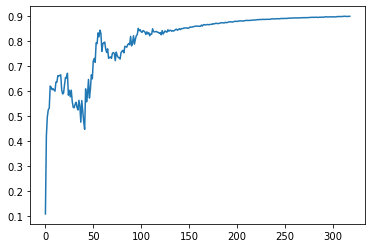

In [7]:
plt.plot(torch.tensor(score_list))

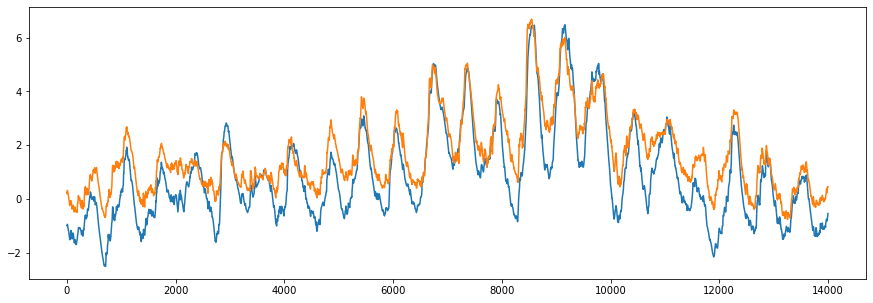

In [8]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[16000:30000])
plt.plot(test_V_pred.cpu().detach().numpy()[16000:30000])

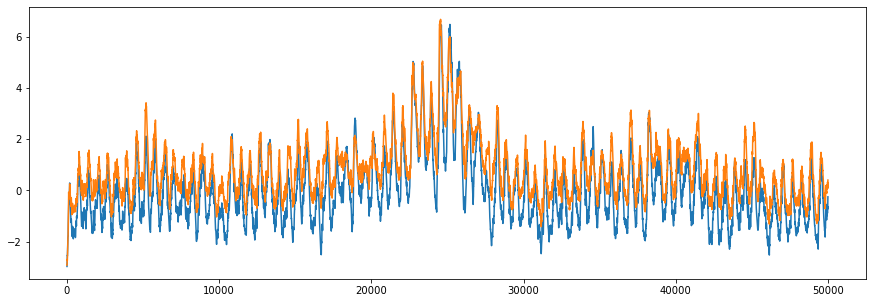

In [9]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[:])
plt.plot(test_V_pred.cpu().detach().numpy())

In [10]:
kern_basis = torch.zeros(24, T_no).to(device)
for i in range(24):
    phi = 1.5707963267948966*i
    xmin = phi - 3.141592653589793
    xmax = phi + 3.141592653589793

    x_in = torch.arange(0, T_no, 1)
    raw_cos = 6  * torch.log(x_in + 1 + 1e-7)

    basis = 0.5*torch.cos(raw_cos - phi) + 0.5
    basis[raw_cos < xmin] = 0.0
    basis[raw_cos > xmax] = 0.0
    kern_basis[i] = basis
    
kern_e = torch.matmul(model.W_e_layer1, kern_basis)
kern_i = torch.matmul(model.W_i_layer1, kern_basis)
kern_e = kern_e.cpu().detach().numpy()
kern_i = kern_i.cpu().detach().numpy()

scale_e = model.E_scale.cpu().detach().numpy()
scale_i = model.I_scale.cpu().detach().numpy()

C_syn_e = test_C_syn_e.cpu().detach().numpy()
C_syn_i = test_C_syn_i.cpu().detach().numpy()

print(kern_e.shape)
print(kern_i.shape)
print(scale_e.shape)
print(scale_i.shape)

(14, 500)
(14, 500)
(2000,)
(200,)


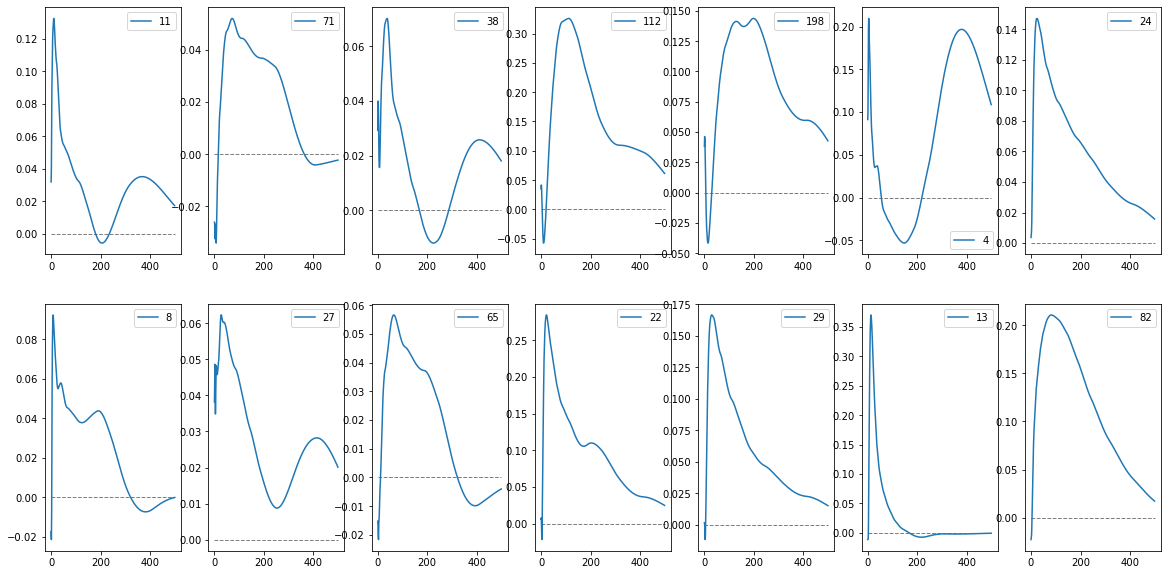

In [11]:
fig, axs = plt.subplots(nrows = H_no, ncols= sub_no, figsize = (20,10))

for i in range(H_no):
    for j in range(sub_no):
        idx = j*H_no + i
        max_t = np.argmax(np.abs(kern_e[idx]))
        axs[i,j].plot(kern_e[idx], label=str(max_t))
        axs[i,j].hlines(y=0, xmin=0, xmax=T_no, linewidth=1, linestyle="--", color="gray")
        axs[i,j].legend()

In [12]:
C_syn_plot = np.zeros((E_no))

for e in range(E_no):
    C_syn_plot[e] = torch.argmax(model.C_syn_e_raw[:,e])

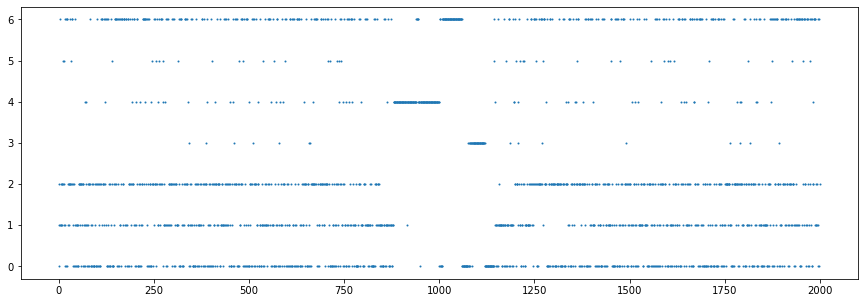

In [13]:
plt.figure(figsize = (15,5))
plt.scatter(np.arange(E_no), C_syn_plot, s=1)

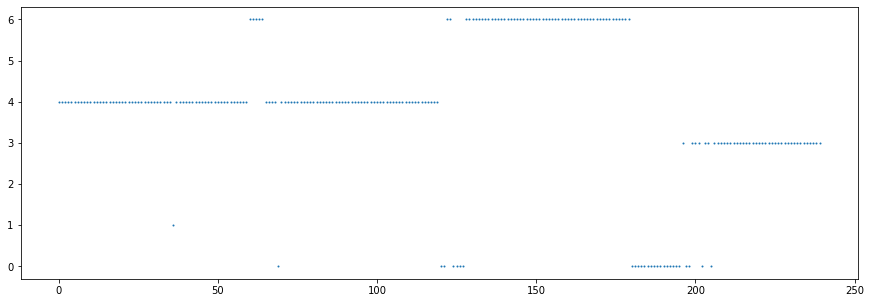

In [14]:
plt.figure(figsize = (15,5))
plt.scatter(np.arange(240), C_syn_plot[880:1120], s=1)

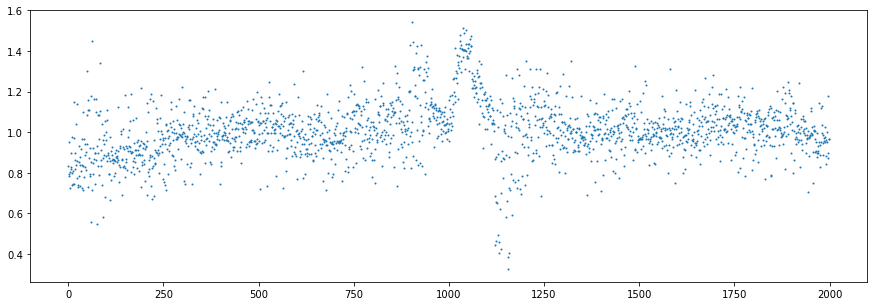

In [16]:
plt.figure(figsize = (15,5))
plt.scatter(np.arange(E_no), np.exp(model.E_scale.cpu().detach().numpy()), s=1)

In [15]:
#torch.save(model.state_dict(), "/media/hdd01/sklee/CA1_clust4-60/glm_diff_clust_s8_h2.pt")

#np.savez("/media/hdd01/sklee/CA1_clust4-60/glm_diff_clust_s8_h2_output.npz",
         test = test_V_pred.cpu().detach().numpy().flatten(),
         kern_e = kern_e,
         kern_i = kern_i,
         scale_e = scale_e,
         scale_i = scale_i,
         C_syn_e = C_syn_e,
         C_syn_i = C_syn_i)

IndentationError: unexpected indent (<ipython-input-15-af3a805dc390>, line 4)